In [1]:
import numpy as np
import pandas as pd
from sklearn import decomposition as dc
from matplotlib import pyplot as plt

# NMF to Decompose Q, SQ, HQ spectra

In [2]:
# LOAD THE DATA

# use this to cut the data at low wavelengths
low_wavelength_cutoff = 60

wavelengths = np.arange(260 + low_wavelength_cutoff, 751, dtype=float)
wl_slice = np.s_[:,2 + low_wavelength_cutoff:len(wavelengths)+2+low_wavelength_cutoff]
spectra = {}


# static oxidized
d = np.genfromtxt('./raw_data/ox->red/Raw_cuvette_oxidized.CSV', skip_header=7, delimiter=';')[wl_slice]
assert np.all(d[0] == wavelengths), (0, d[0], wavelengths)
spectra[0] = d[1] - np.min(d[1,:])


# oxidized to reduced
for i in range(1,17):
    
    if i == 10: continue # severe outlier
    
    d = np.genfromtxt('./raw_data/ox->red/%dmin.CSV' % i, skip_header=7, delimiter=';')[wl_slice]
    assert np.all(d[0] == wavelengths), (i, d[0], wavelengths)
    spectra[i] = d[1] - np.min(d[1,:])

    
# reduced to oxidized
for i in [10, 20, 45, 50, 60, 70, 95]:
    d = np.genfromtxt('./raw_data/red->ox/%dmin.CSV' % i, skip_header=7, delimiter=';')[wl_slice]
    assert np.all(d[0] == wavelengths), (i, d[0], wavelengths)
    spectra[-i] = d[1] - np.min(d[1,:])

In [3]:
keys = list(spectra.keys())
print(keys)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, -10, -20, -45, -50, -60, -70, -95]


(23, 431)
-70


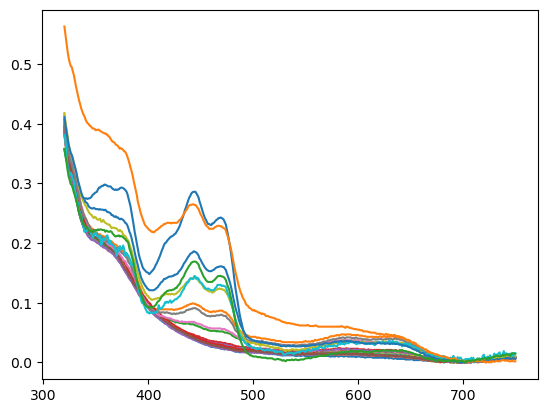

In [4]:
X = np.vstack([ spectra[k] for k in keys ])
print(X.shape)
if np.any(np.isnan(X)):
    print(' !! nans in X')
    
print(keys[np.argmax(X.sum(1))])

plt.figure()
plt.plot(wavelengths, X.T)
plt.show()

In [5]:
nmf = dc.NMF(n_components=3, max_iter=5000)
W = nmf.fit_transform(X)
H = nmf.components_

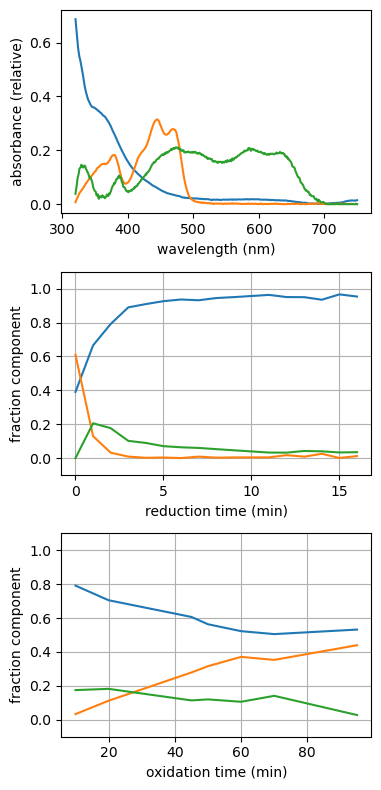

In [6]:
plt.figure(figsize=(4,8))

axT = plt.subplot(311)
axT.plot(wavelengths, H.T)
axT.set_xlabel('wavelength (nm)')
axT.set_ylabel('absorbance (relative)')


x_ox_to_red = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16]
n = len(x_ox_to_red)
W_1 = W[:n,:] / W.sum(1)[:n,None]

axM = plt.subplot(312)
axM.plot(x_ox_to_red, W_1)
axM.grid()
axM.set_ylim([-0.1, 1.1])
axM.set_xlabel('reduction time (min)')
axM.set_ylabel('fraction component')

x_red_to_ox = [10, 20, 45, 50, 60, 70, 95]
m = len(x_red_to_ox)
W_2 = W[n:,:] / W.sum(1)[n:,None]

axB = plt.subplot(313)
axB.plot(x_red_to_ox, W_2)
axB.grid()
axB.set_ylim([-0.1, 1.1])
axB.set_xlabel('oxidation time (min)')
axB.set_ylabel('fraction component')

plt.tight_layout()
plt.show()

# Use the NMF results to try and esimate the fraction of SQ at the end of the SwissFEL beamtime

"50 us crystal slurry + 500 ul degased protein buffer (20 mM Tris, 150 mM NaCl, pH=7) prepared inside the glovebox and transferred for measurement in the nanodrop"

In [7]:
before_transit  = np.loadtxt('./swissfelxtalspectrapretravel.tsv', skiprows=9)
after_transit   = np.loadtxt('./aftertravelswissfel.tsv', skiprows=9)
end_of_beamtime = np.loadtxt('./pl mmcpd 1july22 1758h.tsv', skiprows=9)

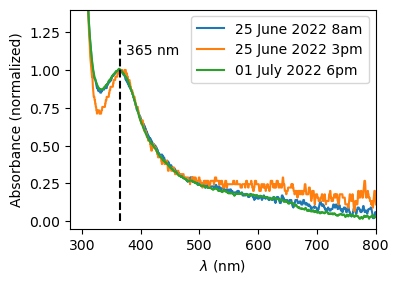

In [9]:

plt.figure(figsize=(4,3))

# axL = plt.subplot(121)

# for x in [before_transit, after_transit, end_of_beamtime]:
#     axL.plot(x[:,0], x[:,1] - x[:,1].min())

# axL.set_xlim([280, 800])
# axL.set_ylim([-0.01, 0.3])

# axL.set_xlabel('$\lambda$ (nm)')
# axL.set_ylabel('Absorbance (AU)')

# ---------
# normalized plot

norm_wavelength = 365.0

#axR = plt.subplot(122)
axR = plt.subplot(111)

for x in [before_transit, after_transit, end_of_beamtime]:
    norm_idx = np.argmin( np.abs(x[:,0] - norm_wavelength) )
    x_norm = x[:,1] - np.min(x[:,1])
    x_norm = x_norm / x_norm[norm_idx]
    axR.plot(x[:,0], x_norm)

axR.vlines(norm_wavelength, 0, 1.2, color='k', linestyles='dashed')
axR.text(norm_wavelength + 10, 1.1, '%d nm' % norm_wavelength)

axR.set_xlim([280, 800])
axR.set_ylim([-0.05, 1.4])

axR.set_xlabel('$\lambda$ (nm)')
axR.set_ylabel('Absorbance (normalized)')

axR.legend(['25 June 2022 8am', '25 June 2022 9pm', '01 July 2022 6pm'])

plt.tight_layout()
# plt.savefig('../figures/redox_state_of_crystals.pdf')
# plt.savefig('../figures/redox_state_of_crystals.eps')
plt.savefig('../figures/redox_state_of_crystals.png')
plt.show()
